# Capstone Project - Eye For Blind

An CNN-RNN based Attention model has been built on flickr8k dataset to predict captions for random images. The Model selects captions using Greedy Search and resulting captions are evaluated using BLUE score.

In [1]:
#Import all the required libraries

import warnings
warnings.filterwarnings("ignore")

import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
from PIL import Image
import random

# Date and Time 
import datetime,time

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter
import operator

# tensorflow , KERAS Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import text_to_word_sequence
from tqdm import tqdm
from keras.utils.vis_utils import plot_model


# Model building 
from sklearn.model_selection import train_test_split


In [2]:
!pip install kagglehub

Let's read the dataset

In [3]:
import kagglehub
if os.path.isdir('/kaggle/input/flickr8k'):
  print("Flickr8K already present")
else:
    # Download latest version
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    print("Path to dataset files:", path)

Flickr8K already present


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [4]:
## images and text path
images_path='/kaggle/input/flickr8k/Images'

text_path= '/kaggle/input/flickr8k/captions.txt'

In [5]:
#Import the dataset and read the image into a seperate variable
all_imgs = glob.glob(images_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [6]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
    lines = []
    with open(filename) as f:
        lines = f.readlines()
        f.close()
    return lines

In [7]:
doc = load_doc(text_path)

## deleting the 1st line from the text as its the header
del doc[0]

print(doc[:3])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n']


In [8]:
#Visualise both the images & text present in the dataset

def Visualise_image_text(image):
    imgPath_vis = all_imgs[0]
    plt.figure(figsize=(6,4))
    plt.imshow(mpimg.imread(imgPath_vis))

    for i in range(len(doc)):
        filename = os.path.basename(imgPath_vis)
        if str(doc[i]).__contains__(filename):
            print(doc[i][len(filename)+1:])

A dog in a snowy area .

A spotted dog catching a ball on a snowy field .

A white and brown spotted dog runs along the snow to catch a ball .

A white dog is running fast on a trail covered by snow .

The brown and white dog is playing in the snow .



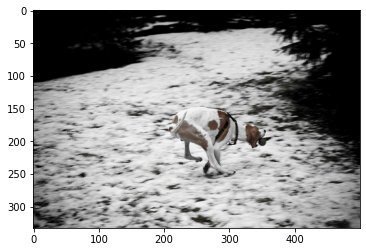

In [9]:
#Plotting one Image & texts
Visualise_image_text(all_imgs[0])

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [10]:
print("No of Images:" , len(all_imgs))
print("No of Captions:" , len(doc))

No of Images: 8091
No of Captions: 40455


In [11]:
dataframe_file = "dataframe_file.pkl"

In [12]:
### save and read the dataframe that stores image id , path and captions so that we don't have to rerun the model everytime.

def read_dataframe(filename):
  ##if file is not extracted the extarct and use it
  read_df = pd.read_pickle(filename)
  return read_df

def save_dataframe(filename,dataframe):
  dataframe.to_pickle(filename)

In [13]:
all_img_id= []#store all the image id here
all_img_vector= []#store all the image path here
annotations= [] #store all the captions here

## if df file is present then read from there else create df file
if os.path.isfile(dataframe_file):
    df = read_dataframe(dataframe_file)
    all_img_id= df.ID
    all_img_vector= df.Path
    annotations= df.Captions
else: ## create the dataframe and save it for future use
    for i in range(len(all_imgs)):
        fileName = os.path.basename(all_imgs[i])
        filePath = all_imgs[i]
        for j in range(len(doc)):
            if str(doc[j]).__contains__(fileName):
                annotations.append(str(doc[j][len(fileName)+1:]).strip())
                all_img_id.append(fileName)
                all_img_vector.append(filePath)                
    df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
    save_dataframe(dataframe_file,df)
    
df.head(10)

,ID,Path,Captions
0,3226254560_2f8ac147ea.jpg,/kaggle/input/flickr8k/Images/3226254560_2f8ac...,A dog in a snowy area .
1,3226254560_2f8ac147ea.jpg,/kaggle/input/flickr8k/Images/3226254560_2f8ac...,A spotted dog catching a ball on a snowy field .
2,3226254560_2f8ac147ea.jpg,/kaggle/input/flickr8k/Images/3226254560_2f8ac...,A white and brown spotted dog runs along the s...
3,3226254560_2f8ac147ea.jpg,/kaggle/input/flickr8k/Images/3226254560_2f8ac...,A white dog is running fast on a trail covered...
4,3226254560_2f8ac147ea.jpg,/kaggle/input/flickr8k/Images/3226254560_2f8ac...,The brown and white dog is playing in the snow .
5,214543992_ce6c0d9f9b.jpg,/kaggle/input/flickr8k/Images/214543992_ce6c0d...,A black and white dog is playing with a ball o...
6,214543992_ce6c0d9f9b.jpg,/kaggle/input/flickr8k/Images/214543992_ce6c0d...,A black and white dog jumps up as a ball is th...
7,214543992_ce6c0d9f9b.jpg,/kaggle/input/flickr8k/Images/214543992_ce6c0d...,dog jumping looking up and small white ball in...
8,214543992_ce6c0d9f9b.jpg,/kaggle/input/flickr8k/Images/214543992_ce6c0d...,The black and white dog is attempting to catch...
9,214543992_ce6c0d9f9b.jpg,/kaggle/input/flickr8k/Images/214543992_ce6c0d...,The dog jumps up waiting to catch something be...


In [14]:
## sorting the dataframe based on image id
df.sort_values(by="ID",inplace=True)

In [15]:
## checking the shape of the fianl dataframe
df.shape

(40455, 3)

In [16]:
#Create the vocabulary & the counter for the captions
filter_chars = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
vocabulary={} 

for lines in df.Captions:
  ## using keras api to convert lines to words
  for word in text_to_word_sequence(lines,filters=filter_chars,lower=True, split=' '):
      ## adding the word to the dict and the count  
      if word not in vocabulary:
        vocabulary[word] = 1
      else:
        vocabulary[word] = vocabulary[word] + 1

val_count=len(vocabulary)
val_count

8493

In [17]:
## creating a dataframe for the words and count
df_word = pd.DataFrame.from_dict(vocabulary, orient='index')
df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
df_word =df_word.rename(columns={'index':'word', 0:'count'})

In [18]:
## function to Visualise words and count
def show_top_words(index,words,count):
    plt.figure(figsize=(20,3))
    plt.bar(words,count,color='maroon', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Word Count",rotation=90,fontsize=20) 
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title("The top "+ str(len(index)) + " most frequently appearing words",fontsize=20)
    plt.show()

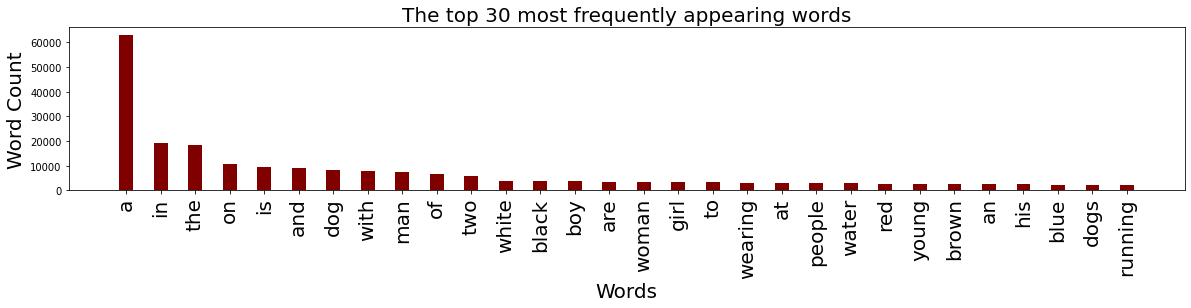

In [19]:
#Visualise the top 30 occuring words in the captions
words = list(df_word[0:30].word)
count =list(df_word['count'][0:30])
show_top_words(list(range(0,30)),words,count)

In [20]:
## Add <start> and <end> tags in the words
df['Captions']=df.Captions.apply(lambda x : f"<start> {x} <end>")

In [21]:
## disply the updated captions
df.head(5)

,ID,Path,Captions
36093,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing the stairs to h...
36090,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A child in a pink dress is climbing up...
36091,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A girl going into a wooden building . ...
36092,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl climbing into a wooden p...
36094,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,<start> A little girl in a pink dress going in...


In [22]:
#Create a list which contains all the captions
annotations=df['Captions']

# Find max length of sequence excluding the spaces between words
max_length = max(df.Captions.apply(lambda x : len(x.split())))

#Create a list which contains all the path to the images
all_img_path = df.Path
unique_img = df.Path.unique()
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print("Total Unique images present in the dataset: " + str(len(unique_img)))
print("Max words of a sentence is :",max_length)

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
Total Unique images present in the dataset: 8091
Max words of a sentence is : 40


In [23]:
## function to plot image and text side by side
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=10)

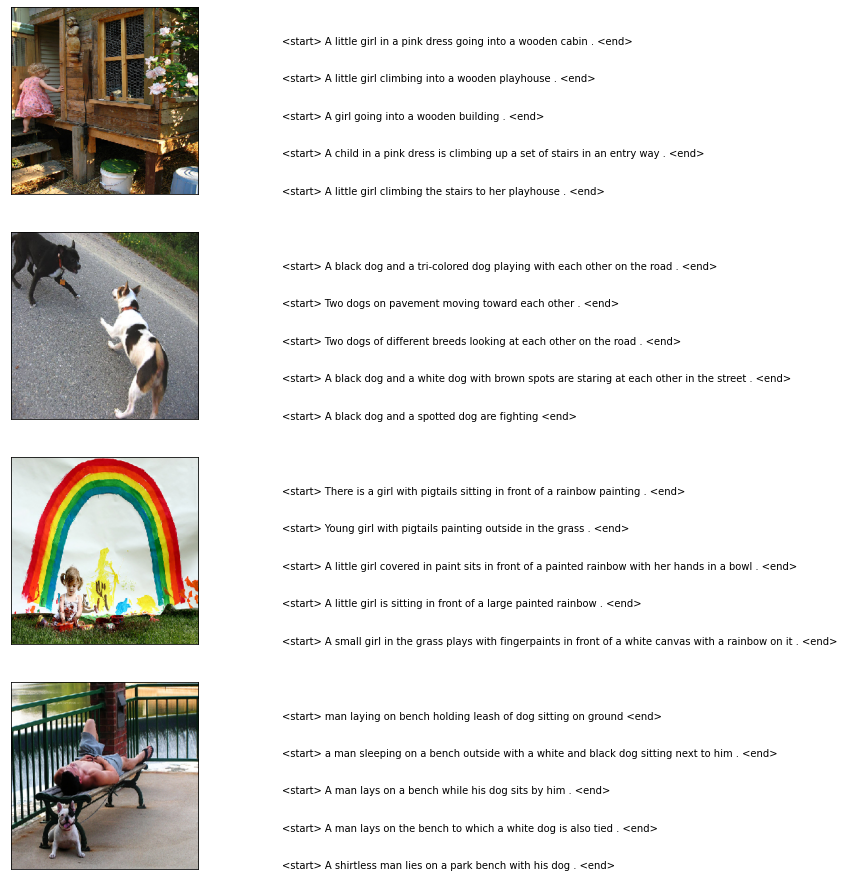

In [24]:
## Show 5 images and corresponding text side by side 
fig = plt.figure(figsize=(10,20))
count = 1
    
for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [25]:
# create the tokenizer function
def tokenize_captions(top_freq_words,captions):
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_freq_words,
                                                  oov_token="UNK",
                                                  filters=special_chars,
                                                  lower=True, split=' ', char_level=False)
    tokenizer.fit_on_texts(captions)
    
    # Adding PAD to tokenizer list on index 0
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'   
   
    return tokenizer

In [26]:
# Create the tokenized vectors
top_freq_words = 5000
tokenizer = tokenize_captions(top_freq_words,df['Captions'])
cap_seqs = tokenizer.texts_to_sequences(df['Captions'])

In [27]:
cap_seqs[:5]

[[3, 2, 41, 20, 120, 6, 394, 21, 61, 2438, 4],
 [3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 395, 13, 394, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [28]:
# Create word-to-index and index-to-word mappings functions.
def show_word_2_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

def show_index_2_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

In [29]:
### show word-to-index and index-to-word mappings 
          
print("------Word to Index------")
show_word_2_index("PAD")
show_word_2_index("UNK")
show_word_2_index("<start>")
show_word_2_index("<end>")

print('\n')

print("-------Index to Word--------")
show_index_2_word(2)
show_index_2_word(1500)
show_index_2_word(3000)
show_index_2_word(4999)

------Word to Index------
Word = PAD, index = 0
Word = UNK, index = 1
Word = <start>, index = 3
Word = <end>, index = 4


-------Index to Word--------
Index = 2, Word = a
Index = 1500, Word = houses
Index = 3000, Word = serving
Index = 4999, Word = nadal


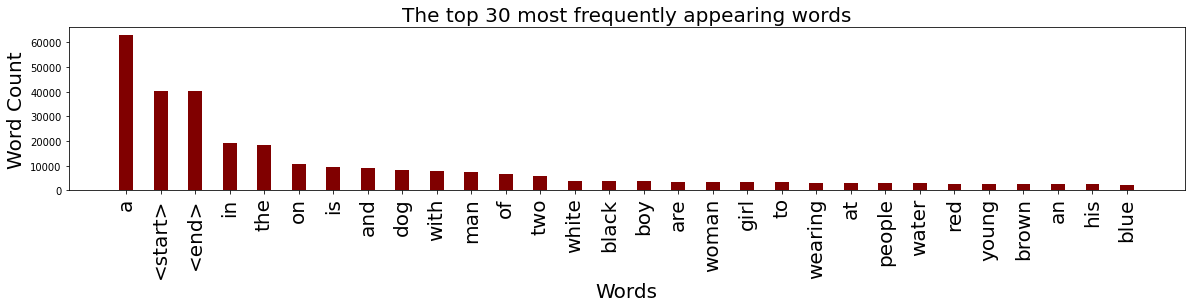

In [30]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

word_count = pd.DataFrame.from_dict(tokenizer.word_counts,orient='index')
word_count.sort_values(by=[0],ascending=False , inplace=True)

words = list(word_count[0:30].index)
count =list(word_count[0:30][0])
show_top_words(list(range(0,30)),words,count)

In [31]:
# Pad each vector to the max_length of the captions & store it to a vairable

# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5])

The shape of Caption vector is :(40455, 39)
[[   3    2   41   20  120    6  394   21   61 2438    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   44    5    2   91  173    8  120   52    2  395   13  394
     5   29    1  671    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   20  317   65    2  197  118    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120   65    2  197 2438    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20    5    2   91  173  317   65    2  197 2982    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [32]:
## as we will be using Inception V3 for trasfer learning for encoding , thats why using image size as below
image_shape = (299, 299)

In [33]:
def preprocess_image(image_path):
    ## applying tensorflow api to read img file , convert image jpeg file to array with reshape
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,image_shape) 
    ## preprocess image i.e normalize in corect format for Inception V3
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(image)

    return preprocessed_image,image_path

Image Shape : (299, 299, 3)


Image Vector Values after normalize :

 (<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]],

       [[-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        ]

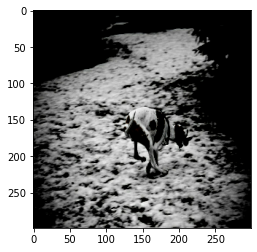

In [34]:
## checking the function with one image 
preprocessed_image = preprocess_image(all_img_vector[0])
print("Image Shape :", preprocessed_image[0].shape)
print("\n")
print("Image Vector Values after normalize :\n\n",preprocessed_image)
print("\n Display Image after processing:\n")
plt.imshow(preprocess_image(all_img_vector[0])[0])

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
BATCH_SIZE = 512

In [36]:
# Creating Image dataset of preprocessed images into batches
images_path = sorted(set(all_img_vector)) ## taking only the unique paths
image_dataset = tf.data.Dataset.from_tensor_slices(images_path)
image_dataset = image_dataset.map(preprocess_image , num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

In [37]:
### creating train and test split of image paths and caption vectors
image_train, image_test, caption_train, caption_test = train_test_split(df.Path,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [38]:
## checking size of each train and test sets
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [39]:
## building the transfer learning model to extract the features from the images
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

## input same shape as InceptionV3 and we have preprocessed the image vector accordingly
new_input = image_model.input

## output same shape as InceptionV3 last dense layer , not the softmax layer as we dropped it while model selection above
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)
image_features_extract_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [40]:
### filename for saving the img features after extract
img_feature_dict_filename = 'img_feature_dict.npy'

In [41]:
### save and read the feature directory so that we don't have to rerun the model everytime.

def read_img_features(filename):
  ##if file is not extracted the extarct and use it
  read_dictionary = np.load(filename,allow_pickle='TRUE').item()
  return read_dictionary

def save_img_features(filename,feature_dict):
  np.save(filename, feature_dict)

In [42]:
## extracting the feature vector from each image and saving it in dictionary
image_feature_dict = {}

## if extarcted file is present or the zip is present then read from there else create feature file
if os.path.isfile(img_feature_dict_filename):
  ## extract the image features
  image_feature_dict = read_img_features(img_feature_dict_filename)

else:
  for image,path in tqdm(image_dataset):
      ## extracting features via transfer learning model
      batch_features = image_features_extract_model(image)
      batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
      for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        ## creating the dictionary via img path as id and feature vector as value
        image_feature_dict[path_of_feature] =  batch_f.numpy()  

  ## save the image features for reuse
  save_img_features(img_feature_dict_filename,image_feature_dict)
    

100%|██████████| 16/16 [01:11<00:00,  4.46s/it]


In [43]:
### function to get the img features and captions together
def map_function(image_name,caption):
    image_tensor = image_feature_dict[image_name.decode('utf-8')]
    return image_tensor,caption

In [44]:
### function to create a dataset having image feature vector and corresponding caption vector , using autotune and batch fetch
BUFFER_SIZE = 3000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE) ## shuffling the dataset

    ## applying the map function on the dataset to extract the image features from the previously created image_feature_dict via the img path value
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) ## appling prefetch based on Autotune buffer size for utilizing optimal resource
    return dataset

In [45]:
### creating the test and train dataset after shuffle and batch
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [46]:
## checking the shape of the sample batch for image and captions vector
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(512, 64, 2048)
(512, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [47]:
embedding_dim = 256 
units = 512
vocab_size = 5001

### Encoder

In [48]:
## this will take the features vectors already created via Inception V3 model above and reduce the dimension as per embedding vector shape 
## so as to keep both feature and caption vector in same shape for Attention model
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim , activation="relu") ## applying relu activation on the fc layer
        self.dropout = layers.Dropout(0.4) ## applying dropout on the fc layer to reduce overfitting
        
    def call(self, features):
        features = self.fc(features)
        return features

In [49]:
## creating object of the Encoder model
encoder=Encoder(embedding_dim)

### Attention model

In [50]:
## this custom model will take the feature vector from encoding model and 
## hidden vector from the decoding RNN model and create the context vector based on attention weights calculated 

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units) ## for Img Feature Vector from Encoder
        self.W2 = layers.Dense(units) ## for Caption Hidden Vector from Decoder
        self.V = layers.Dense(1) ## for Scoring based on Feature & Hidden Vector
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) ## adding an extra dimention to Hidden Decoder vector to match feature vector dimension
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) ## calculating the score vector from Feature and Hidden Vector
        attention_weights =  keras.activations.softmax(self.V(score), axis=1) ## converting the Score vector into attention weights via Softmax layer
        context_vector = attention_weights * features ## creating the context vector from Feature vector
        context_vector = tf.reduce_sum(context_vector, axis=1) 
        return context_vector, attention_weights

### Decoder

In [51]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units ## setting the decoder units
        self.attention = Attention_model(self.units) ## setting the attanetion model units for creating the W1 & W2 dense layers
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False) ## creating an embeding layer for converting the caption vector as per embed dimension which matches the encoder output layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') ## defining the RNN GRU for predicting the words sequencially
        self.d1 = layers.Dense(self.units) ## defining a dense layer as per the decoder units
        self.d2 = layers.Dense(vocab_size) ## defining a dense layer for final decoder output  
        self.dropout = layers.Dropout(0.4) ## defining a dropout on the fc layer to reduce overfitting
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) ## calling the attention model to provide the context vector
        embed = self.dropout(self.embed(x)) ## applying the dropout defined above on the embedding layer
        mask = self.embed.compute_mask(x) ## applying masking on the  embedded input caption vector to not consider the padded values for model traning
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) ## concatting the captions embedded masked vector with the context vector
        output,state = self.gru(embed,mask=mask) ## passing the final embedded vector after concat into the GRU
        output = self.d1(output) ##passing the output of GRU via the dense layer 1 defined above
        output = tf.reshape(output, (-1, output.shape[2])) ## reshaping the output layer of dense layer 1
        output = self.d2(output) ## passing the final output via the last dense layer 2 for match the output vector dimension
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
## creating the decoder object
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
## checking the different model output shape from sample train batch
features=encoder(sample_img_batch) ## creating the encoder model

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0]) ## creating the initial hidden layer
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1) ## creating the decoder input

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden) ## creating the decoder model
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (512, 64, 256)
Predcitions shape from Decoder: (512, 5001)
Attention weights shape from Decoder: (512, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [54]:
## defining the optimizer and loss objects
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
##optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [55]:
## creating the custom loss function which handles the padded values while calculating the mean loss

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) ## creating the mask because we don't want to consider captions padding values for loss function else it will be wrong
    
    loss_ = loss_object(real, pred) ## calculating the loss value via the keras.losses.SparseCategoricalCrossentropy

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask ## applying the masked value on the top of loss output so that we don't consider padded value's loss

    return tf.reduce_mean(loss_) ## returning the mean loss value

In [56]:
## defining the checkpoint object to save the group of trackable objects to a checkpoint file during model training
checkpoint_path = "/content/checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

In [57]:
## if model training breaks in between, when we start it again then it will check for last checkpoint 
## and start the epoch from there else will start from 0
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [58]:
## using tensorflow functions decorator in order to turn plain Python code into graph for faster computation

@tf.function
def train_step(img_tensor, target): ##defining the model training function
    loss = 0 ## setting the initail loss to 0
    hidden = decoder.init_state(batch_size=target.shape[0]) ## setting up the initial hidden layer
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) ## expanding the initial decorator input dimesnion by 1 from caption vector
    
    ## using gradiant tape for handling custom gradiant decent to update weights on the models
    with tf.GradientTape() as tape:
        features = encoder(img_tensor) ## extracting feature vector via the encoder
        for i in range(1, target.shape[1]): ## running loop though each word in he caption vector
            predictions, hidden, _ = decoder(dec_input, features, hidden) ## getting the output from the decoder
            loss += loss_function(target[:, i], predictions) ## calculating the loss from the decoder output and actual target word
            dec_input = tf.expand_dims(target[:, i], 1) ## decoder input with the actual word
        avg_loss = (loss/int(target.shape[1])) ## calculating the average loss after all words are passed
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables ## finding all the trainable variables from the excoder and decoder models
    gradients = tape.gradient(loss, trainable_variables) ## calculating the derivative of the total loss by all the trainable variables
    optimizer.apply_gradients(zip(gradients, trainable_variables)) ## applying the Adams optimizer based on the trainable variables based on the gradiant calculated
    return loss, avg_loss

In [59]:
## using tensorflow functions decorator in order to turn plain Python code into graph for faster computation

@tf.function
def test_step(img_tensor, target):##defining the model testing function
    each_batch_loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0]) ## setting up the initial hidden layer
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) ## expanding the initial decorator input dimesnion by 1 from caption vector

    features = encoder(img_tensor) ## extracting feature vector via the encoder

    ## iterating through each actual word and calculating the loss from prediction
    for i in range(1, target.shape[1]):
      predictions, hidden, _ = decoder(dec_input, features, hidden)
      each_batch_loss += loss_function(target[:, i], predictions) ## calculating the loss by comparing with actual words
      dec_input = tf.expand_dims(target[:, i], 1) ## decoder input with actual word

    avg_batch_loss = (each_batch_loss / int(target.shape[1])) ## mean loss of each word predicted

    return each_batch_loss, avg_batch_loss

In [60]:
## function to calculate the average test data loss
def test_loss_cal(test_dataset):
    total_avg_batch_loss = 0
    test_num_steps = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        each_batch_loss, avg_batch_loss = test_step(img_tensor, target) ## finding the batch lossfrom test dataset
        total_avg_batch_loss += avg_batch_loss
        test_num_steps = test_num_steps + 1
    avg_test_loss=total_avg_batch_loss/test_num_steps ## calculating he avg test loss from all the batches
    return avg_test_loss

In [61]:
## Array to plot the train and test loss 
loss_plot = []
test_loss_plot = []

In [62]:
## executing the model training process , calcuting the training loss and test dataset loss on the model

EPOCHS = 200 ## max epoch
stop_epoch_count = 0

best_test_loss=100

for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_avg_batch_loss = 0
    train_num_steps = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        total_loss, avg_loss = train_step(img_tensor, target) ## finding the total and avg batch loss of train data
        total_avg_batch_loss += avg_loss ## summing up the average loss
        train_num_steps = train_num_steps + 1

    avg_train_loss=total_avg_batch_loss / train_num_steps ##calculating the average of the total no of batches
    loss_plot.append(avg_train_loss) ## appending the traning loss to plot graph   
    test_loss = test_loss_cal(test_dataset) ## calculating the loss from test data
    test_loss_plot.append(test_loss) ## appending the testing loss to plot graph 
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    ## for each epoch is the test data loss is less than previous then saving the model via checkpoint
    if round(float(test_loss),3) < best_test_loss :
      print('Test loss has been reduced from %.3f to %.3f thus saving the checkpoint \n\n' % (best_test_loss, test_loss))
      best_test_loss = round(float(test_loss),3)
      stop_epoch_count = 0 ## reset counter once checkpoint saved
      ## save the group of trackable objects to a checkpoint file.
      ckpt_manager.save()
    else:
      stop_epoch_count = stop_epoch_count + 1 ##increase counter for non improve test loss epoch
      print("No Test Loss improvement in this Epoch\n")
      if stop_epoch_count >= 5: ## if loss doesn't reduce in last 5 epochs then stop execution
        print("No Improvement in Test Loss , hence we have reached the Global Minima. Stopping Epoch run.")
        break 

  0%|          | 0/200 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.908, & test loss is 1.621
Time taken for 1 epoch 140.1974003314972 sec

Test loss has been reduced from 100.000 to 1.621 thus saving the checkpoint 




  1%|          | 2/200 [03:04<4:36:56, 83.92s/it] 

For epoch: 2, the train loss is 1.606, & test loss is 1.611
Time taken for 1 epoch 44.196162700653076 sec

Test loss has been reduced from 1.621 to 1.611 thus saving the checkpoint 




  2%|▏         | 3/200 [03:49<3:37:08, 66.14s/it]

For epoch: 3, the train loss is 1.587, & test loss is 1.579
Time taken for 1 epoch 44.80692982673645 sec

Test loss has been reduced from 1.611 to 1.579 thus saving the checkpoint 




  2%|▏         | 4/200 [04:35<3:09:16, 57.94s/it]

For epoch: 4, the train loss is 1.531, & test loss is 1.507
Time taken for 1 epoch 45.22009229660034 sec

Test loss has been reduced from 1.579 to 1.507 thus saving the checkpoint 




  2%|▎         | 5/200 [05:20<2:53:51, 53.49s/it]

For epoch: 5, the train loss is 1.464, & test loss is 1.449
Time taken for 1 epoch 45.46666502952576 sec

Test loss has been reduced from 1.507 to 1.449 thus saving the checkpoint 




  3%|▎         | 6/200 [06:06<2:44:31, 50.88s/it]

For epoch: 6, the train loss is 1.406, & test loss is 1.392
Time taken for 1 epoch 45.6583456993103 sec

Test loss has been reduced from 1.449 to 1.392 thus saving the checkpoint 




  4%|▎         | 7/200 [06:52<2:38:28, 49.27s/it]

For epoch: 7, the train loss is 1.342, & test loss is 1.329
Time taken for 1 epoch 45.769657135009766 sec

Test loss has been reduced from 1.392 to 1.329 thus saving the checkpoint 




  4%|▍         | 8/200 [07:38<2:34:24, 48.25s/it]

For epoch: 8, the train loss is 1.279, & test loss is 1.273
Time taken for 1 epoch 45.91758441925049 sec

Test loss has been reduced from 1.329 to 1.273 thus saving the checkpoint 




  4%|▍         | 9/200 [08:24<2:31:24, 47.56s/it]

For epoch: 9, the train loss is 1.225, & test loss is 1.231
Time taken for 1 epoch 45.90160274505615 sec

Test loss has been reduced from 1.273 to 1.231 thus saving the checkpoint 




  5%|▌         | 10/200 [09:10<2:29:10, 47.11s/it]

For epoch: 10, the train loss is 1.188, & test loss is 1.202
Time taken for 1 epoch 45.93560194969177 sec

Test loss has been reduced from 1.231 to 1.202 thus saving the checkpoint 




  6%|▌         | 11/200 [09:56<2:27:25, 46.80s/it]

For epoch: 11, the train loss is 1.158, & test loss is 1.178
Time taken for 1 epoch 45.945120096206665 sec

Test loss has been reduced from 1.202 to 1.178 thus saving the checkpoint 




  6%|▌         | 12/200 [10:42<2:25:59, 46.59s/it]

For epoch: 12, the train loss is 1.135, & test loss is 1.159
Time taken for 1 epoch 45.96408987045288 sec

Test loss has been reduced from 1.178 to 1.159 thus saving the checkpoint 




  6%|▋         | 13/200 [11:29<2:24:47, 46.46s/it]

For epoch: 13, the train loss is 1.115, & test loss is 1.144
Time taken for 1 epoch 45.98251295089722 sec

Test loss has been reduced from 1.159 to 1.144 thus saving the checkpoint 




  7%|▋         | 14/200 [12:15<2:23:44, 46.37s/it]

For epoch: 14, the train loss is 1.097, & test loss is 1.129
Time taken for 1 epoch 46.004830837249756 sec

Test loss has been reduced from 1.144 to 1.129 thus saving the checkpoint 




  8%|▊         | 15/200 [13:01<2:22:47, 46.31s/it]

For epoch: 15, the train loss is 1.080, & test loss is 1.115
Time taken for 1 epoch 46.03022384643555 sec

Test loss has been reduced from 1.129 to 1.115 thus saving the checkpoint 




  8%|▊         | 16/200 [13:47<2:21:56, 46.29s/it]

For epoch: 16, the train loss is 1.064, & test loss is 1.105
Time taken for 1 epoch 46.082727909088135 sec

Test loss has been reduced from 1.115 to 1.105 thus saving the checkpoint 




  8%|▊         | 17/200 [14:33<2:21:06, 46.26s/it]

For epoch: 17, the train loss is 1.049, & test loss is 1.093
Time taken for 1 epoch 46.05459523200989 sec

Test loss has been reduced from 1.105 to 1.093 thus saving the checkpoint 




  9%|▉         | 18/200 [15:20<2:20:18, 46.25s/it]

For epoch: 18, the train loss is 1.037, & test loss is 1.085
Time taken for 1 epoch 46.080453872680664 sec

Test loss has been reduced from 1.093 to 1.085 thus saving the checkpoint 




 10%|▉         | 19/200 [16:06<2:19:32, 46.26s/it]

For epoch: 19, the train loss is 1.024, & test loss is 1.073
Time taken for 1 epoch 46.10397481918335 sec

Test loss has been reduced from 1.085 to 1.073 thus saving the checkpoint 




 10%|█         | 20/200 [16:52<2:18:46, 46.26s/it]

For epoch: 20, the train loss is 1.014, & test loss is 1.064
Time taken for 1 epoch 46.10982060432434 sec

Test loss has been reduced from 1.073 to 1.064 thus saving the checkpoint 




 10%|█         | 21/200 [17:38<2:18:03, 46.28s/it]

For epoch: 21, the train loss is 1.002, & test loss is 1.055
Time taken for 1 epoch 46.1704888343811 sec

Test loss has been reduced from 1.064 to 1.055 thus saving the checkpoint 




 11%|█         | 22/200 [18:25<2:17:15, 46.27s/it]

For epoch: 22, the train loss is 0.992, & test loss is 1.050
Time taken for 1 epoch 46.09792518615723 sec

Test loss has been reduced from 1.055 to 1.050 thus saving the checkpoint 




 12%|█▏        | 23/200 [19:11<2:16:30, 46.27s/it]

For epoch: 23, the train loss is 0.982, & test loss is 1.044
Time taken for 1 epoch 46.12025856971741 sec

Test loss has been reduced from 1.050 to 1.044 thus saving the checkpoint 


For epoch: 24, the train loss is 0.972, & test loss is 1.035
Time taken for 1 epoch 45.97063946723938 sec

Test loss has been reduced from 1.044 to 1.035 thus saving the checkpoint 




 12%|█▏        | 24/200 [19:57<2:15:38, 46.24s/it]

For epoch: 25, the train loss is 0.964, & test loss is 1.029
Time taken for 1 epoch 46.01085710525513 sec

Test loss has been reduced from 1.035 to 1.029 thus saving the checkpoint 




 13%|█▎        | 26/200 [21:30<2:14:04, 46.23s/it]

For epoch: 26, the train loss is 0.956, & test loss is 1.024
Time taken for 1 epoch 46.05257272720337 sec

Test loss has been reduced from 1.029 to 1.024 thus saving the checkpoint 




 14%|█▎        | 27/200 [22:16<2:13:14, 46.21s/it]

For epoch: 27, the train loss is 0.948, & test loss is 1.019
Time taken for 1 epoch 46.010701417922974 sec

Test loss has been reduced from 1.024 to 1.019 thus saving the checkpoint 




 14%|█▍        | 28/200 [23:02<2:12:27, 46.21s/it]

For epoch: 28, the train loss is 0.940, & test loss is 1.015
Time taken for 1 epoch 46.04008507728577 sec

Test loss has been reduced from 1.019 to 1.015 thus saving the checkpoint 




 14%|█▍        | 29/200 [23:48<2:11:38, 46.19s/it]

For epoch: 29, the train loss is 0.933, & test loss is 1.009
Time taken for 1 epoch 46.01185154914856 sec

Test loss has been reduced from 1.015 to 1.009 thus saving the checkpoint 




 15%|█▌        | 30/200 [24:34<2:10:54, 46.20s/it]

For epoch: 30, the train loss is 0.925, & test loss is 1.005
Time taken for 1 epoch 46.083959341049194 sec

Test loss has been reduced from 1.009 to 1.005 thus saving the checkpoint 




 16%|█▌        | 31/200 [25:21<2:10:08, 46.20s/it]

For epoch: 31, the train loss is 0.918, & test loss is 1.002
Time taken for 1 epoch 46.051443338394165 sec

Test loss has been reduced from 1.005 to 1.002 thus saving the checkpoint 




 16%|█▌        | 32/200 [26:07<2:09:22, 46.20s/it]

For epoch: 32, the train loss is 0.911, & test loss is 0.999
Time taken for 1 epoch 46.05648326873779 sec

Test loss has been reduced from 1.002 to 0.999 thus saving the checkpoint 




 16%|█▋        | 33/200 [26:53<2:08:36, 46.21s/it]

For epoch: 33, the train loss is 0.906, & test loss is 0.995
Time taken for 1 epoch 46.05612373352051 sec

Test loss has been reduced from 0.999 to 0.995 thus saving the checkpoint 




 17%|█▋        | 34/200 [27:39<2:07:49, 46.20s/it]

For epoch: 34, the train loss is 0.898, & test loss is 0.990
Time taken for 1 epoch 46.03658890724182 sec

Test loss has been reduced from 0.995 to 0.990 thus saving the checkpoint 




 18%|█▊        | 35/200 [28:25<2:06:57, 46.17s/it]

For epoch: 35, the train loss is 0.893, & test loss is 0.990
Time taken for 1 epoch 46.083603620529175 sec

No Test Loss improvement in this Epoch



 18%|█▊        | 36/200 [29:11<2:06:12, 46.17s/it]

For epoch: 36, the train loss is 0.888, & test loss is 0.986
Time taken for 1 epoch 46.02440094947815 sec

Test loss has been reduced from 0.990 to 0.986 thus saving the checkpoint 




 18%|█▊        | 37/200 [29:58<2:05:28, 46.19s/it]

For epoch: 37, the train loss is 0.882, & test loss is 0.983
Time taken for 1 epoch 46.0605149269104 sec

Test loss has been reduced from 0.986 to 0.983 thus saving the checkpoint 




 19%|█▉        | 38/200 [30:44<2:04:41, 46.18s/it]

For epoch: 38, the train loss is 0.876, & test loss is 0.979
Time taken for 1 epoch 46.00547242164612 sec

Test loss has been reduced from 0.983 to 0.979 thus saving the checkpoint 




 20%|█▉        | 39/200 [31:30<2:03:55, 46.18s/it]

For epoch: 39, the train loss is 0.871, & test loss is 0.977
Time taken for 1 epoch 46.0335168838501 sec

Test loss has been reduced from 0.979 to 0.977 thus saving the checkpoint 




 20%|██        | 40/200 [32:16<2:03:12, 46.20s/it]

For epoch: 40, the train loss is 0.865, & test loss is 0.975
Time taken for 1 epoch 46.06012988090515 sec

Test loss has been reduced from 0.977 to 0.975 thus saving the checkpoint 




 20%|██        | 41/200 [33:02<2:02:27, 46.21s/it]

For epoch: 41, the train loss is 0.861, & test loss is 0.973
Time taken for 1 epoch 46.07560396194458 sec

Test loss has been reduced from 0.975 to 0.973 thus saving the checkpoint 




 21%|██        | 42/200 [33:49<2:01:41, 46.21s/it]

For epoch: 42, the train loss is 0.855, & test loss is 0.971
Time taken for 1 epoch 46.06927704811096 sec

Test loss has been reduced from 0.973 to 0.971 thus saving the checkpoint 




 22%|██▏       | 43/200 [34:35<2:00:54, 46.20s/it]

For epoch: 43, the train loss is 0.850, & test loss is 0.969
Time taken for 1 epoch 46.034188747406006 sec

Test loss has been reduced from 0.971 to 0.969 thus saving the checkpoint 




 22%|██▏       | 44/200 [35:21<2:00:00, 46.16s/it]

For epoch: 44, the train loss is 0.846, & test loss is 0.969
Time taken for 1 epoch 46.043394565582275 sec

No Test Loss improvement in this Epoch



 22%|██▎       | 45/200 [36:07<1:59:15, 46.17s/it]

For epoch: 45, the train loss is 0.842, & test loss is 0.966
Time taken for 1 epoch 46.03852677345276 sec

Test loss has been reduced from 0.969 to 0.966 thus saving the checkpoint 




 23%|██▎       | 46/200 [36:53<1:58:31, 46.18s/it]

For epoch: 46, the train loss is 0.837, & test loss is 0.964
Time taken for 1 epoch 46.04465913772583 sec

Test loss has been reduced from 0.966 to 0.964 thus saving the checkpoint 




 24%|██▎       | 47/200 [37:40<1:57:46, 46.18s/it]

For epoch: 47, the train loss is 0.831, & test loss is 0.963
Time taken for 1 epoch 46.05981683731079 sec

Test loss has been reduced from 0.964 to 0.963 thus saving the checkpoint 




 24%|██▍       | 48/200 [38:26<1:57:01, 46.20s/it]

For epoch: 48, the train loss is 0.827, & test loss is 0.961
Time taken for 1 epoch 46.06225061416626 sec

Test loss has been reduced from 0.963 to 0.961 thus saving the checkpoint 




 24%|██▍       | 49/200 [39:12<1:56:16, 46.20s/it]

For epoch: 49, the train loss is 0.823, & test loss is 0.959
Time taken for 1 epoch 46.06487727165222 sec

Test loss has been reduced from 0.961 to 0.959 thus saving the checkpoint 




 25%|██▌       | 50/200 [39:58<1:55:24, 46.16s/it]

For epoch: 50, the train loss is 0.819, & test loss is 0.960
Time taken for 1 epoch 46.0665488243103 sec

No Test Loss improvement in this Epoch



 26%|██▌       | 51/200 [40:44<1:54:41, 46.19s/it]

For epoch: 51, the train loss is 0.815, & test loss is 0.958
Time taken for 1 epoch 46.08510732650757 sec

Test loss has been reduced from 0.959 to 0.958 thus saving the checkpoint 




 26%|██▌       | 52/200 [41:30<1:53:56, 46.19s/it]

For epoch: 52, the train loss is 0.810, & test loss is 0.955
Time taken for 1 epoch 46.06362509727478 sec

Test loss has been reduced from 0.958 to 0.955 thus saving the checkpoint 




 26%|██▋       | 53/200 [42:17<1:53:11, 46.20s/it]

For epoch: 53, the train loss is 0.806, & test loss is 0.954
Time taken for 1 epoch 46.053404808044434 sec

Test loss has been reduced from 0.955 to 0.954 thus saving the checkpoint 




 27%|██▋       | 54/200 [43:03<1:52:17, 46.15s/it]

For epoch: 54, the train loss is 0.802, & test loss is 0.954
Time taken for 1 epoch 46.02893137931824 sec

No Test Loss improvement in this Epoch



 28%|██▊       | 55/200 [43:49<1:51:35, 46.18s/it]

For epoch: 55, the train loss is 0.799, & test loss is 0.952
Time taken for 1 epoch 46.0926251411438 sec

Test loss has been reduced from 0.954 to 0.952 thus saving the checkpoint 




 28%|██▊       | 56/200 [44:35<1:50:43, 46.13s/it]

For epoch: 56, the train loss is 0.793, & test loss is 0.952
Time taken for 1 epoch 46.031585454940796 sec

No Test Loss improvement in this Epoch



 28%|██▊       | 57/200 [45:21<1:50:00, 46.16s/it]

For epoch: 57, the train loss is 0.791, & test loss is 0.951
Time taken for 1 epoch 46.044553995132446 sec

Test loss has been reduced from 0.952 to 0.951 thus saving the checkpoint 




 29%|██▉       | 58/200 [46:07<1:49:16, 46.17s/it]

For epoch: 58, the train loss is 0.787, & test loss is 0.950
Time taken for 1 epoch 46.05403208732605 sec

Test loss has been reduced from 0.951 to 0.950 thus saving the checkpoint 




 30%|██▉       | 59/200 [46:53<1:48:24, 46.13s/it]

For epoch: 59, the train loss is 0.782, & test loss is 0.954
Time taken for 1 epoch 46.0365629196167 sec

No Test Loss improvement in this Epoch



 30%|███       | 60/200 [47:40<1:47:43, 46.17s/it]

For epoch: 60, the train loss is 0.782, & test loss is 0.949
Time taken for 1 epoch 46.08960723876953 sec

Test loss has been reduced from 0.950 to 0.949 thus saving the checkpoint 




 30%|███       | 61/200 [48:26<1:47:00, 46.19s/it]

For epoch: 61, the train loss is 0.777, & test loss is 0.948
Time taken for 1 epoch 46.08766007423401 sec

Test loss has been reduced from 0.949 to 0.948 thus saving the checkpoint 




 31%|███       | 62/200 [49:12<1:46:16, 46.21s/it]

For epoch: 62, the train loss is 0.772, & test loss is 0.947
Time taken for 1 epoch 46.09229302406311 sec

Test loss has been reduced from 0.948 to 0.947 thus saving the checkpoint 




 32%|███▏      | 63/200 [49:58<1:45:23, 46.16s/it]

For epoch: 63, the train loss is 0.769, & test loss is 0.947
Time taken for 1 epoch 46.04896640777588 sec

No Test Loss improvement in this Epoch



 32%|███▏      | 64/200 [50:44<1:44:33, 46.13s/it]

For epoch: 64, the train loss is 0.766, & test loss is 0.947
Time taken for 1 epoch 46.054476261138916 sec

No Test Loss improvement in this Epoch



 32%|███▎      | 65/200 [51:30<1:43:49, 46.15s/it]

For epoch: 65, the train loss is 0.760, & test loss is 0.946
Time taken for 1 epoch 46.04063272476196 sec

Test loss has been reduced from 0.947 to 0.946 thus saving the checkpoint 




 33%|███▎      | 66/200 [52:16<1:42:58, 46.11s/it]

For epoch: 66, the train loss is 0.759, & test loss is 0.947
Time taken for 1 epoch 46.019875288009644 sec

No Test Loss improvement in this Epoch



 34%|███▎      | 67/200 [53:03<1:42:16, 46.14s/it]

For epoch: 67, the train loss is 0.755, & test loss is 0.943
Time taken for 1 epoch 46.04766345024109 sec

Test loss has been reduced from 0.946 to 0.943 thus saving the checkpoint 




 34%|███▍      | 68/200 [53:49<1:41:27, 46.12s/it]

For epoch: 68, the train loss is 0.751, & test loss is 0.946
Time taken for 1 epoch 46.06760287284851 sec

No Test Loss improvement in this Epoch



 34%|███▍      | 69/200 [54:35<1:40:39, 46.10s/it]

For epoch: 69, the train loss is 0.749, & test loss is 0.944
Time taken for 1 epoch 46.0711133480072 sec

No Test Loss improvement in this Epoch



 35%|███▌      | 70/200 [55:21<1:39:52, 46.10s/it]

For epoch: 70, the train loss is 0.745, & test loss is 0.946
Time taken for 1 epoch 46.07989692687988 sec

No Test Loss improvement in this Epoch



 36%|███▌      | 71/200 [56:07<1:39:05, 46.09s/it]

For epoch: 71, the train loss is 0.743, & test loss is 0.945
Time taken for 1 epoch 46.07742261886597 sec

No Test Loss improvement in this Epoch



 36%|███▌      | 71/200 [56:53<1:43:22, 48.08s/it]

For epoch: 72, the train loss is 0.738, & test loss is 0.943
Time taken for 1 epoch 46.14076209068298 sec

No Test Loss improvement in this Epoch

No Improvement in Test Loss , hence we have reached the Global Minima. Stopping Epoch run.


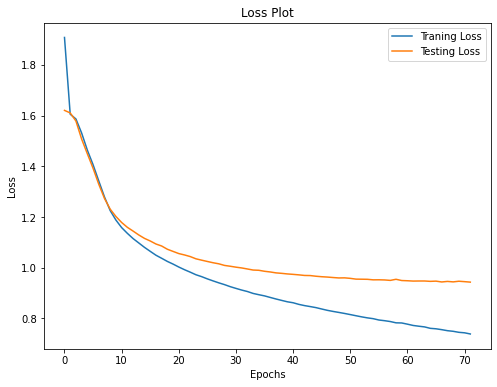

In [63]:
## plotting the traning and testing dataset avg loss values
plt.figure(figsize=(8,6))
plt.plot(loss_plot,label='Traning Loss')
plt.plot(test_loss_plot,label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [64]:
def evaluate(image):
    max_length=39

    hidden = decoder.init_state(batch_size=1) ## creating the hiden state for 1 item for Decoder model

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) ## extracting the features from img via Inception V3 transfer learning
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) ## reshapring the image

    attention_plot = np.zeros((max_length, img_tensor_val.shape[1])) ## creating the attention feature vector based on the caption max lenth

    features = encoder(img_tensor_val) ## passing the feature vector via encoder model

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) ## creating the initial Decoder input
    result = []

    for i in range(max_length): ## running the loop though the max word count of the caption vector
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) ## predicting each word via the Decoder model

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() ## adding the addention weights for the word returned from Decoder into attention_plot

        predicted_id = tf.argmax(predictions[0]).numpy() ## extracting the max probability word token from predictions vector
        result.append(tokenizer.index_word[predicted_id]) ## converting the token to word and saving it into list

        if tokenizer.index_word[predicted_id] == '<end>': ## if reach end of line via end tag then return and exit
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0) ## else Decoder input the next word

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search

In [65]:
def beam_evaluate(image, beam_index = 3):
    max_length=39
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) ## extracting the features from img via Inception V3 transfer learning
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) ## reshapring the image

    attention_plot = np.zeros((max_length, img_tensor_val.shape[1])) ## creating the attention feature vector based on the caption max lenth

    features = encoder(img_tensor_val) ## passing the feature vector via encoder model

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) ## creating the initial Decoder input

    while len(result[0][0]) < max_length: ## running a loop though the max number of words
        i=0
        temp = []
        for s in result: ## running loop through each word predicted and stored in results list
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden) ## preduct the words from decoder along with attanetion wts and hidden layer
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() ## adding the addention weights for the word returned from Decoder into attention_plot
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:] ## selecting the max probality words by sorting based on beam index provided as input i.e top 3
          
            for w in word_preds: ## running a loop through the top beam index words from predictions vector returned above
                next_cap, prob = s[0][:], s[1] ## fetching the word and probability of the next word
                next_cap.append(w) 
                prob += np.log(predictions[0][w]) ## calculating the cumulative sum of probabilities of the top words predicted and appeneded 
                temp.append([next_cap, prob]) ##saving the combilation and total probaility in a variable
        result = temp ## once out of aloop sav ethe temp into results
        result = sorted(result, reverse=False, key=lambda l: l[1]) ## sort the results array in reverse order to get the max probability combination on top
        result = result[-beam_index:] ##selecting gthe top beam index combinations
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3): ## break if reach <end> tag
            dec_input = tf.expand_dims([prd_id], 0)  ## providing the best combination as input to the Decoder in next run
        else:
            break
    
    
    result2 = result[-1][0]
    
    ## creating the setence from the caption vector values
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption ,attention_plot

In [66]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image)) ## extracting the image array
    
    len_cap = len(caption) ## getting the max lenth of the caption
    for cap in range(len_cap): ## looping through the max word count and displaying the focused area of the image from where the word is predicted
        weights_img = np.reshape(weights[cap], (8,8)) ## getting the attention weight vector on each word
        weights_img = np.array(Image.fromarray(weights_img).resize(image_shape, Image.LANCZOS)) ## reshaping the weight vector
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1) ## calculating the number of subplots based on no of words
        ax.set_title(caption[cap], fontsize=15) ## displaying the word predicted from each part of the focussed image
        
        img=ax.imshow(temp_img) ## displaying the actual image
        
        ## putting an overlay on top of the actual image to focus on a particular area based the attention weights for that word
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent()) 

        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [67]:
from nltk.translate.bleu_score import sentence_bleu

In [68]:
## fuction to remove start end and unk tags from the captions predicted
def filt_text(text):
    filt=['<start>','UNK','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

Random Test Image ID : 9796

Mean BELU score for Greedy Search:  20.549

Mean BELU score for Beam Search:  36.74

Greedy Search Prediction Caption: a woman in a woman in a tree

Beam Search Prediction Caption: a woman in front of a woman dress and white dress and white dress and white dress and white dress and white dress and white dress and white dress and white dress and white dress and white shirt

Greedy Search Plot:


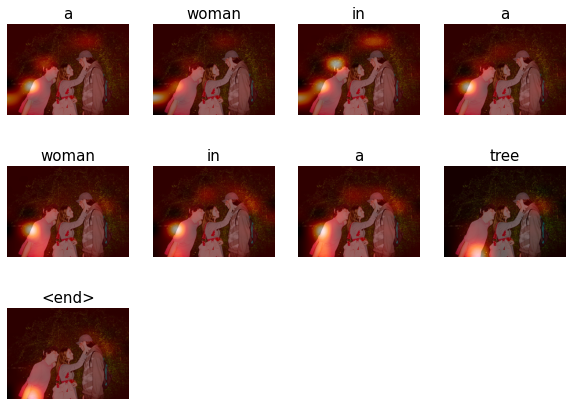


Real Captions:
A girl is touching a man 's ear in front of a tree while another man leans in .
A young woman touching a young man 's cheek while a friend looks on
"Girl touches young man 's face as young man in pink shirt observes , leafy background ."
"a girl touches the side of a young man 's head , while another young man watches ."
Three people are near a tree and the woman touches one of the men 's faces .


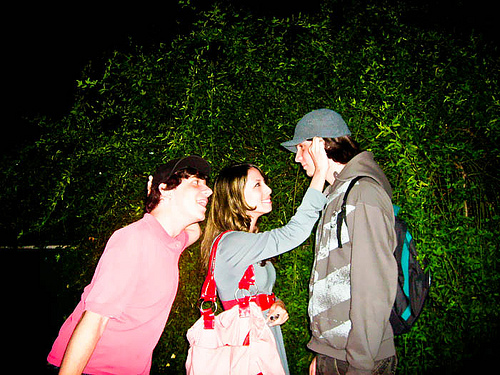

In [69]:
rid = np.random.randint(0,len(df)) ## selecting a random index from dataframe
print("Random Test Image ID :" , rid)
test_image = df.Path[rid]

## getting the real caption from the df
real_captions = df.Captions[df.Path == test_image]

## extarting the prediction words from the image along with attention weight vctor for each word from Greedy search
greedy_result, greedy_attention_plot,pred_test = evaluate(test_image)

## extarting the prediction words from the image along with attention weight vector for each word from Beam search
beam_result, beam_attention_plot = beam_evaluate(test_image)

## creating the prediction sentence
greedy_pred_caption=' '.join(greedy_result).rsplit(' ', 1)[0]
greedy_candidate = greedy_pred_caption.split() ## predicted word list from greedy search
beam_candidate = beam_result.split() ## predicted word list beam search

filtered_real_captions = [] ## this is used to display with the actual image

greedy_bleu_score = 0
beam_bleu_score = 0

for real_caption in real_captions :
  ## removing the start , end and UNK from the real caption sentence
  real_caption=filt_text(real_caption)  

  ## adding the filtered the sentence to the list for future display
  filtered_real_captions.append(real_caption) 

  ## extracting the words from the real caption sentence
  reference = [] 
  reference.append(real_caption.split())

  ## getting the BLEU score for Greedy search words from the predicted and actual words for a image for each real caption
  greedy_bleu_score = greedy_bleu_score + sentence_bleu(reference, greedy_candidate, weights=(0.25, 0.25, 0.25, 0.25))  

  ## getting the BLEU score for Beam search words from the predicted and actual words for a image for each real caption
  beam_bleu_score = beam_bleu_score + sentence_bleu(reference, beam_candidate, weights=(0.25, 0.25, 0.25, 0.25)) 

## showing the average BLEU score comparing with all the actual captions for the image
print("\nMean BELU score for Greedy Search: " , round(((greedy_bleu_score / len(real_captions))*100),3)) 
print("\nMean BELU score for Beam Search: " , round(((beam_bleu_score / len(real_captions))*100),3)) 

print('\nGreedy Search Prediction Caption:', greedy_pred_caption)
print('\nBeam Search Prediction Caption:', beam_result)

## displying the attantion plot map to understand how each is predicted by focusing on each part of image -- Greedy Search
print('\nGreedy Search Plot:')
plot_attmap(greedy_result, greedy_attention_plot, test_image)

print('\nReal Captions:')
for caption in filtered_real_captions :
  print(caption)

## displaying actual image
Image.open(test_image)

## Installing and Importing the Google Text to Speech API

In [70]:
! pip install gTTS

     |████████████████████████████████| 62 kB 745 kB/s             
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
gcsfs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.1.0 which is incompatible.
apache-beam 2.34.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.34.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.2 which is incompatible.
apache-beam 2.34.0 requires pyarrow<6.0.0,>=0.15.1, but you have pyarrow 6.0.1 which is incompatible.


In [71]:
# Import the required module for text to speech conversion
from gtts import gTTS

## Final Function to predict Text & Audio from any input image

In [72]:
def EyeForBlind(imagepath):
  result, __,_ = evaluate(imagepath) ## using Greedy Search
  beam_pred ,_ = beam_evaluate(imagepath) ## using Beam Search

  ## creating the prediction sentence
  pred_caption=' '.join(result).rsplit(' ', 1)[0]

  print('\nImage to Text Caption via Greedy Search :', pred_caption)
  print('\nImage to Text Caption via Beam Search :', beam_pred)
  print('\n')

  ## display the test image
  plt.figure(figsize=(10,8))
  plt.imshow(mpimg.imread(imagepath))

  # Language in which you want to convert
  language = 'en'
  
  # getting the sound from gTTS by passing the predicted caption
  soundobj = gTTS(text=pred_caption, lang=language, slow=False)
  
  # Saving the converted audio in a mp3 file named
  soundobj.save("Image_to_Sound.mp3")

  # Playing the converted file
  os.system("./Image_to_Sound.mp3")
  